# Analysis of June 13th 2022 Flight

Goal: 
1. Import the data one time
2. Plot in modifiable windows
3. Do basic analysis with static mask
4. Show results in pretty plots

In [1]:
# Getting packages #
from os import sys
sys.path.append('../')

%matplotlib widget

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy.io

import plotly.express as px

import main
from main import flight
from main import analysis
import propellers
import motors
from aircraft import airplane
import cl_finders

import data_exporter

from matplotlib.backends.backend_pdf import PdfPages

In [2]:
# Importing data from BIN files #

#df = main.get_data("Alton", "june13_2022.BIN", "10ms")
#df = main.get_data("Alton", "june15_2022.BIN", "1s")

In [3]:
## Pickling that DF for Later ##

#df.to_pickle("../data/june13_2022_100Hz.pkl")

## Unpickling 
df_100Hz = pd.read_pickle("../data/june13_2022_100Hz.pkl")
#df_60Hz = pd.read_pickle("./data/june15_2022_60Hz.pkl")
#df_1Hz = pd.read_pickle("./data/june15_2022_1Hz.pkl")

df = df_100Hz.interpolate(method="linear")

In [4]:
# Vehicle parameters
prop = propellers.aeronaut20x8() # Using aeronaut 20x8 for this flight
motor = motors.U7V2_280KV()  # Using U7 V2 motor

mass = 12.727 # Estimated with virtual bolt included
span = 6.28
chord = 0.395
createv = airplane(mass, chord, span)

P_systems = 4 # Amount of power consumed by everything except the ESC & motor

highorderpolar = True

In [5]:
############# Main Analysis ###############3

# Attitude 
phi = np.deg2rad(df["RollAngle"].to_numpy())            # Bank angle in radians
pitch = np.deg2rad(df["PitchAngle"].to_numpy())         # Pitch angle in radians

# Inertial Measurement Unit
U_dot = df["XAcc_IMU"].to_numpy()                       # Acceleration in X direction

# Atmospheric adjustments:
rho = df["Pressure"].to_numpy() * (287 * (df["Ambient_Temperature"].to_numpy()+273.15))**-1             # Density found from barometer pressure & airspeed sensor temperatures
v_eas = df["Airspeed_Sensor0"].to_numpy()                               # Equivalent SSL airspeed (m/s)
v_tas = v_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed
q = 0.5 * rho * v_tas**2                            # Dynamic pressure 

# For Descent method
h = df["Altitude_POS"].to_numpy()                   # Altitude
Vd_eas = df["DescendingXK"].to_numpy()                  # Descent Rate from EKF (is it true or EAS at SSL?)
Vd_tas = Vd_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed

# Ground speed limiter
v_dem = df["Airspeed_Demanded"].to_numpy()

# Propulsion characterization
n = df["MotorRPM"].to_numpy() / 60                               # Revolutions per second
i_esc = df["EscCurrent"].to_numpy()
v_esc = df["EscVoltage"].to_numpy()
J = v_tas / (n * prop.diameter)
eff = prop.efficiency(J) * motor.efficiency(n, i_esc)

# Estimated propulsive power (New Fitting)
P_eta = cl_finders.eta_steady(prop, motor, v_tas, n, i_esc, v_esc)
P_ct = cl_finders.thrust_steady(prop, rho, v_tas, n)
P_desc = cl_finders.desc2preq(createv, prop, rho, v_tas, n, q, Vd_tas)

P_desc_acc = cl_finders.descU2preq(createv, prop, rho, v_tas, n, q, Vd_tas, pitch, U_dot)
P_hybrid = cl_finders.cruise_highorder(createv, prop, rho, v_tas, Vd_tas, n, pitch, U_dot)

# Getting drag coefficient
Cd_eta = cl_finders.preq2cd(createv, v_tas, q, P_eta)
Cd_ct = cl_finders.preq2cd(createv, v_tas, q, P_ct)
Cd_desc = cl_finders.preq2cd(createv, v_tas, q, P_desc)
Cd_desc_acc = cl_finders.preq2cd(createv, v_tas, q, P_desc_acc)

Cd_hybrid = cl_finders.preq2cd(createv, v_tas, q, P_hybrid)

# Getting lift coefficient
CL = cl_finders.cl_banked(createv, q, phi)

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_53259/2126081776.py:11: RuntimeWarning: invalid value encountered in reciprocal
  rho = df["Pressure"].to_numpy() * (287 * (df["Ambient_Temperature"].to_numpy()+273.15))**-1             # Density found from barometer pressure & airspeed sensor temperatures
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_53259/2126081776.py:13: RuntimeWarning: invalid value encountered in reciprocal
  v_tas = v_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_53259/2126081776.py:19: RuntimeWarning: invalid value encountered in reciprocal
  Vd_tas = Vd_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_53259/2126081776.py:28: RuntimeWarning: divide by zero encountered in true_divide
  J = v_tas / (n * prop.diameter)
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_53259/2126081776.py:28

-0.0031044707175838793
Propeller Drag[nan nan nan ...  0.  0.  0.]
-0.0031044707175838793
Propeller Drag[nan nan nan ...  0.  0.  0.]


/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/Investigations/../cl_finders.py:71: RuntimeWarning: divide by zero encountered in reciprocal
  J_tas = v_tas * (n * propeller.diameter)**-1             # Advance ratio at TAS
/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/Investigations/../cl_finders.py:71: RuntimeWarning: invalid value encountered in reciprocal
  J_tas = v_tas * (n * propeller.diameter)**-1             # Advance ratio at TAS
/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/Investigations/../cl_finders.py:71: RuntimeWarning: invalid value encountered in multiply
  J_tas = v_tas * (n * propeller.diameter)**-1             # Advance ratio at TAS
/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/Investigations/../cl_finders.py:86: RuntimeWarning: invalid value encountered in reciprocal
  J_tas = v_tas * (n * propeller.diameter)**-1
/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/Investigations/../cl_finders.p

/Users/williamkemp/opt/anaconda3/envs/superwake-records/lib/python3.10/site-packages/ipympl/backend_nbagg.py:336: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.figure.savefig(buf, format='png', dpi='figure')


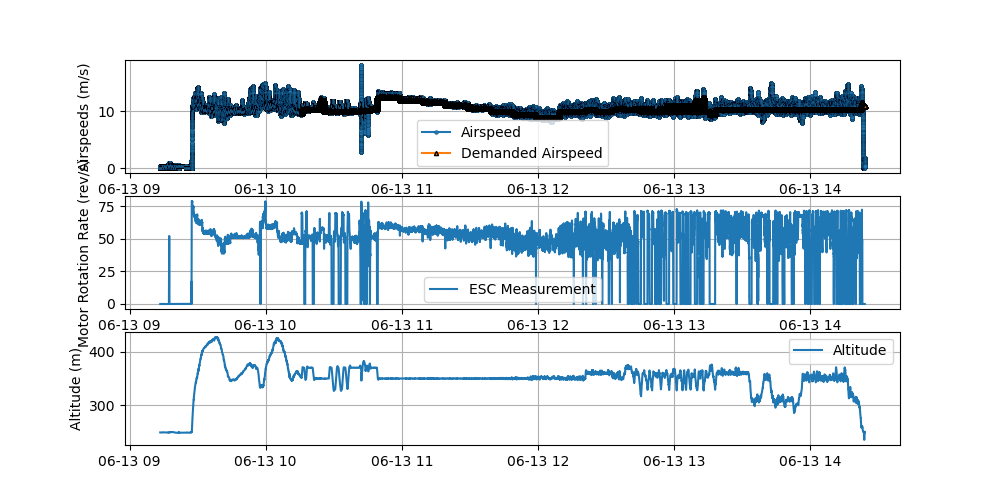

In [6]:
# Plotting true airspeed, with demanded airspeed
plt.figure(figsize=(10,5))
ax1 = plt.subplot(3,1,1)
ax1.plot(df_100Hz.index, v_tas, label="Airspeed", marker='o', markeredgecolor=[0,0,0], markersize=3, markeredgewidth=0.1)
ax1.plot(df_100Hz.index, v_dem, label="Demanded Airspeed", marker='^', markeredgecolor=[0,0,0], markersize=3)
ax1.set_ylabel("Airspeeds (m/s)")
ax1.grid(which='major', linestyle='-')
ax1.grid(which='minor', linestyle=':', color='grey')
plt.legend()

ax2 = plt.subplot(3,1,2, sharex=ax1)
ax2.plot(df.index, n, label='ESC Measurement')
ax2.set_ylabel("Motor Rotation Rate (rev/s)")
ax2.grid(which='major', linestyle='-')
ax2.grid(which='minor', linestyle=':', color='grey')
plt.legend()

ax3 = plt.subplot(3,1,3, sharex=ax1)
ax3.plot(df.index, df.Altitude_POS, label='Altitude')
ax3.set_ylabel("Altitude (m)")
ax3.grid(which='major', linestyle='-')
ax3.grid(which='minor', linestyle=':', color='grey')
plt.legend()

plt.show()

In [7]:
### Mask Initialization ###

# Generating Start/End Times for Segments #
# Producing masks for dataframe

def get_mask(df, start, end, year, month, day):
    # Getting boolean mask from start and end times
    start_time = get_datetime(start, year, month, day)
    end_time = get_datetime(end, year, month, day)
    mask = (df.index > start_time) & (df.index < end_time)
    return mask

def get_datetime(hour_string, year, month, day):
    # Results completed datetime from hour string, and date
    split_nums = hour_string.split(':')
    hours = int(split_nums[0])
    minutes = int(split_nums[1])
    seconds = int(split_nums[2])
    return pd.Timestamp(year=year, month=month, day=day, hour=hours, minute=minutes, second=seconds)

year = 2022
month = 6
day = 13

# Cruise Masking

seg_times = np.array([['10:49:25','10:59:07'],
                      ['10:59:12','11:09:07'],
                      ['11:09:12','11:19:08'],
                      ['11:19:12','11:29:08'],
                      ['11:29:12','11:39:08'],
                      ['11:39:12','11:49:08'],
                      ['11:49:12','11:59:08'],
                      ['11:59:12','12:09:08']])
masks = []
for i in range(np.shape(seg_times)[0]):
    mask = get_mask(df, seg_times[i,0], seg_times[i,1], year, month, day)
    masks.append(mask)

# Descending Masking

# seg_times = np.array([['07:22:05','07:22:53'],
#                       ['07:26:03','07:27:00'],
#                       ['07:30:07','07:31:07'],
#                       ['07:34:02','07:35:07'],
#                       ['07:38:15','07:39:23'],
#                       ['07:42:09','07:43:33'],
#                       ['07:46:31','07:47:44'],
#                       ['07:50:35','07:51:52'],
#                       ['07:54:31','07:55:52'],
#                       ['07:58:44','08:00:17'],
#                       ['08:03:18','08:04:43'],
#                       ['08:07:50','08:09:15'],
#                       ['08:12:18','08:13:46'],
#                       ['08:17:13','08:18:37'],
#                       ['08:22:27','08:23:45'],
#                       ['08:27:36','08:28:54'],
#                       ['08:33:13','08:34:06'],
#                       ['08:38:18','08:39:14'],
#                       ['08:43:38','08:44:59'],
#                       ['08:48:03','08:49:26']
#                       ])
# desc_masks = []
# for i in range(np.shape(seg_times)[0]):
#     mask = get_mask(df, seg_times[i,0], seg_times[i,1], year, month, day)
#     desc_masks.append(mask)


In [8]:
############# Main Analysis ###############3

# Attitude 
phi = np.deg2rad(df["RollAngle"].to_numpy())            # Bank angle in radians
pitch = np.deg2rad(df["PitchAngle"].to_numpy())         # Pitch angle in radians

# Inertial Measurement Unit
U_dot = df["XAcc_IMU"].to_numpy()                       # Acceleration in X direction

# Atmospheric adjustments:
rho = df["Pressure"].to_numpy() * (287 * (df["Ambient_Temperature"].to_numpy()+273.15))**-1             # Density found from barometer pressure & airspeed sensor temperatures
v_eas = df["Airspeed_Sensor0"].to_numpy()                               # Equivalent SSL airspeed (m/s)
v_tas = v_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed
q = 0.5 * rho * v_tas**2                            # Dynamic pressure 

# For Descent method
h = df["Altitude_POS"].to_numpy()                   # Altitude
Vd_eas = df["DescendingXK"].to_numpy()                  # Descent Rate from EKF (is it true or EAS at SSL?)
Vd_tas = Vd_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed

# Ground speed limiter
v_dem = df["Airspeed_Demanded"].to_numpy()

# Propulsion characterization
n = df["MotorRPM"].to_numpy() / 60                               # Revolutions per second
i_esc = df["EscCurrent"].to_numpy()
v_esc = df["EscVoltage"].to_numpy()
J = v_tas / (n * prop.diameter)
eff = prop.efficiency(J) * motor.efficiency(n, i_esc)

# Estimated propulsive power (New Fitting)
P_eta = cl_finders.eta_steady(prop, motor, v_tas, n, i_esc, v_esc)
P_ct = cl_finders.thrust_steady(prop, rho, v_tas, n)
P_desc = cl_finders.desc2preq(createv, prop, rho, v_tas, n, q, Vd_tas)

P_desc_acc = cl_finders.descU2preq(createv, prop, rho, v_tas, n, q, Vd_tas, pitch, U_dot)
P_hybrid = cl_finders.cruise_highorder(createv, prop, rho, v_tas, Vd_tas, n, pitch, U_dot)

# Getting drag coefficient
Cd_eta = cl_finders.preq2cd(createv, v_tas, q, P_eta)
Cd_ct = cl_finders.preq2cd(createv, v_tas, q, P_ct)
Cd_desc = cl_finders.preq2cd(createv, v_tas, q, P_desc)
Cd_desc_acc = cl_finders.preq2cd(createv, v_tas, q, P_desc_acc)

Cd_hybrid = cl_finders.preq2cd(createv, v_tas, q, P_hybrid)

# Getting lift coefficient
CL = cl_finders.cl_banked(createv, q, phi)

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_53259/2126081776.py:11: RuntimeWarning: invalid value encountered in reciprocal
  rho = df["Pressure"].to_numpy() * (287 * (df["Ambient_Temperature"].to_numpy()+273.15))**-1             # Density found from barometer pressure & airspeed sensor temperatures
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_53259/2126081776.py:13: RuntimeWarning: invalid value encountered in reciprocal
  v_tas = v_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_53259/2126081776.py:19: RuntimeWarning: invalid value encountered in reciprocal
  Vd_tas = Vd_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_53259/2126081776.py:28: RuntimeWarning: divide by zero encountered in true_divide
  J = v_tas / (n * prop.diameter)
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_53259/2126081776.py:28

-0.0031044707175838793
Propeller Drag[nan nan nan ...  0.  0.  0.]
-0.0031044707175838793
Propeller Drag[nan nan nan ...  0.  0.  0.]


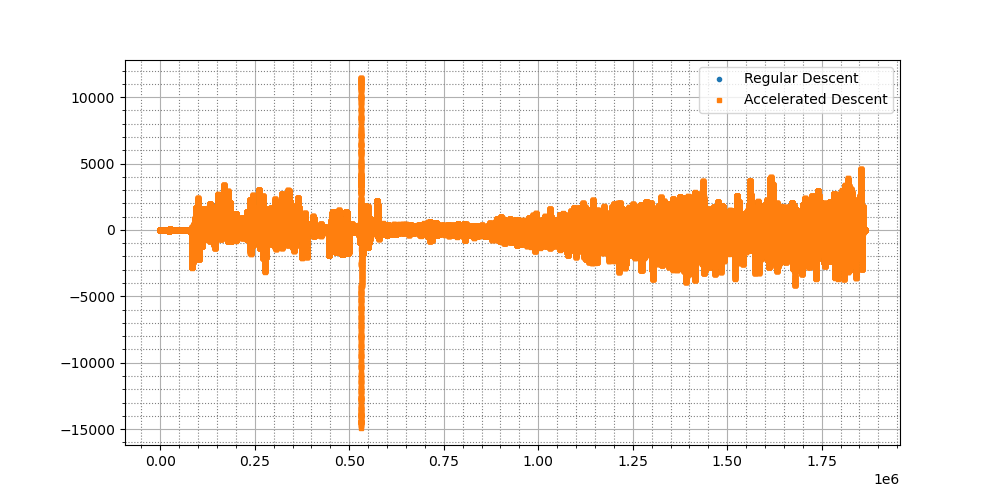

In [9]:
# Getting Visual of Descending Powers #

plt.figure(figsize=(10,5))
plt.plot(P_desc, linestyle='', marker='o', markersize=3, label="Regular Descent")
plt.plot(P_desc_acc, linestyle='', marker='s', markersize=3, label="Accelerated Descent")
plt.legend()
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':', color='grey')
plt.minorticks_on()
plt.show()

In [10]:
# Descending mask

# CDdesc_ave = np.zeros(len(desc_masks))
# CDdescacc_ave = np.zeros(len(desc_masks))

# CLdesc_ave = np.zeros(len(desc_masks))
# CDdesc_std = np.zeros(len(desc_masks))
# CLdesc_std = np.zeros(len(desc_masks))

# EASdesc_ave = np.zeros(len(desc_masks))
# EASdesc_std = np.zeros(len(desc_masks))

# for i in range(len(desc_masks)):
#     CDdesc_ave[i] = np.mean(Cd_desc[desc_masks[i]])
#     CDdescacc_ave[i] = np.mean(Cd_desc_acc[desc_masks[i]])

#     CLdesc_ave[i] = np.mean(CL[desc_masks[i]])
#     EASdesc_ave[i] = np.mean(v_eas[desc_masks[i]])

#     CDdesc_std[i] = np.std(Cd_desc[desc_masks[i]])
#     CLdesc_std[i] = np.std(CL[desc_masks[i]])
#     EASdesc_std[i] = np.std(v_eas[desc_masks[i]])

#     #CDdesc_95[i] = 
#     #CLdesc_95[i] = 
#     #EASdesc_95[i] = 

# polar_desc = cl_finders.cd2polar(createv, CDdesc_ave, CLdesc_ave, highorder=highorderpolar)
# polar_descacc = cl_finders.cd2polar(createv, CDdescacc_ave, CLdesc_ave, highorder=highorderpolar)
# Peq_desc, EAS = cl_finders.polar2preqew(createv, polar_desc, (7,14))
# Peq_descacc, EAS = cl_finders.polar2preqew(createv, polar_descacc, (7,14))

# plt.figure(figsize=(10,5))
# plt.errorbar(CDdesc_ave, CLdesc_ave, xerr=CDdesc_std, yerr=CLdesc_std, fmt='o', label="Descent Method")
# plt.plot(CDdescacc_ave, CLdesc_ave, linestyle='', marker='^', label="Descent Acceleration Method")
# plt.xlabel("Drag Coefficient")
# plt.ylabel("Lift Coefficient")
# plt.legend()
# plt.grid(True)
# plt.show()

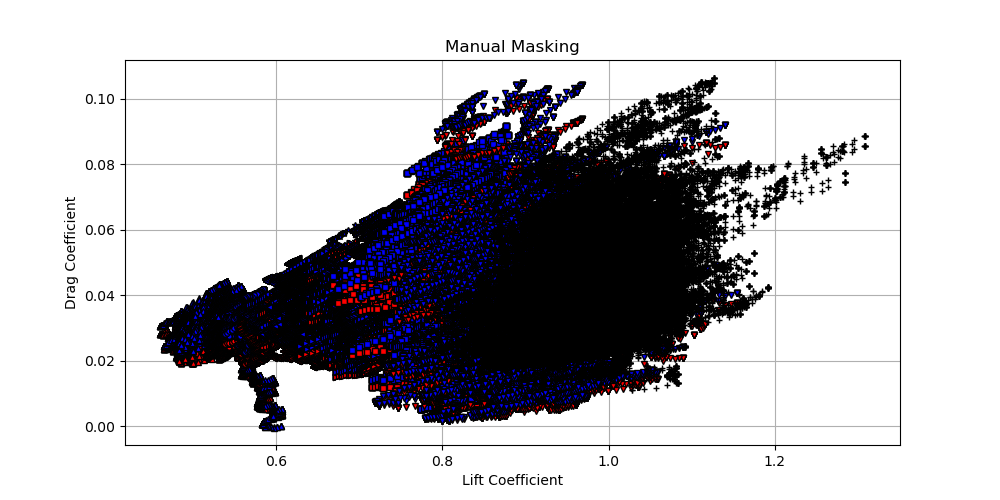

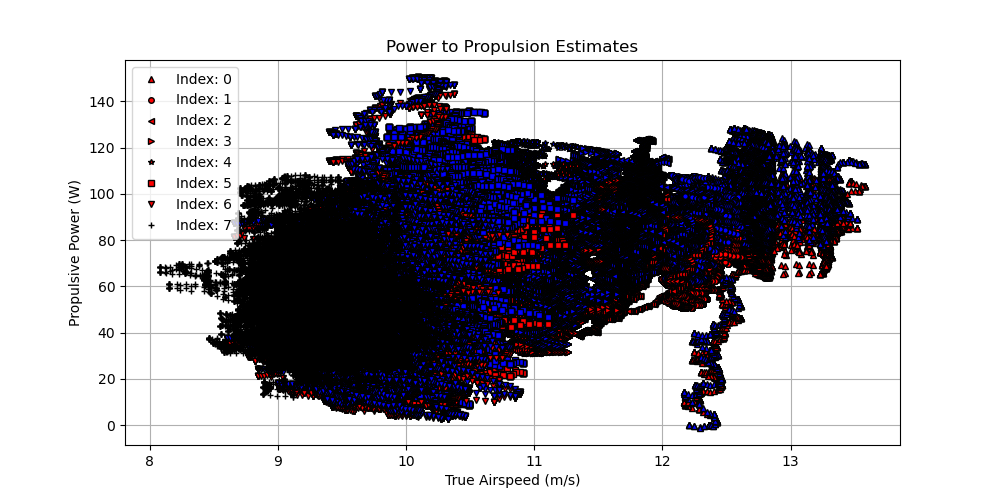

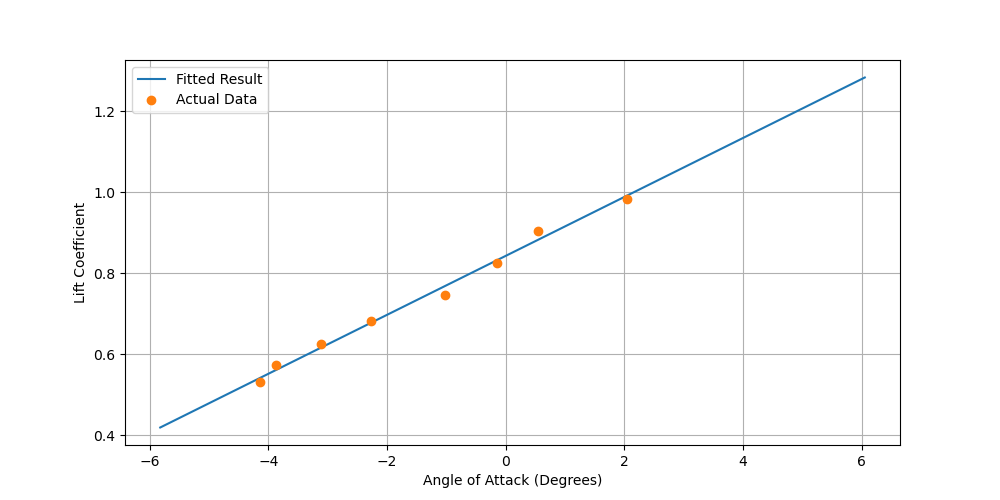

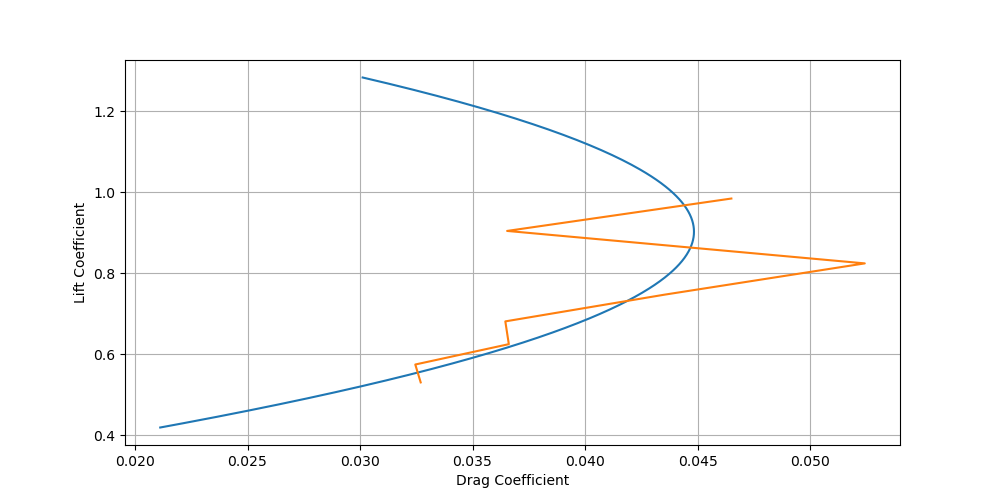

In [11]:
# Plot with static masking
plt.figure(figsize=(10,5))
plt.title("Manual Masking")

markers = ['^', 'o', '<', '>', '*', 's', 'v', '+', 'x', 'D', '.']

for i in range(len(masks)):
    plt.plot(CL[masks[i]], Cd_eta[masks[i]], linestyle='', marker=markers[i], markerfacecolor='r', markersize=4, markeredgecolor=[0,0,0])
    plt.plot(CL[masks[i]], Cd_ct[masks[i]], linestyle='', marker=markers[i], markerfacecolor='b', markersize=4, markeredgecolor=[0,0,0])
    
plt.grid(True)
plt.xlabel("Lift Coefficient")
plt.ylabel("Drag Coefficient")
plt.show()

plt.figure(figsize=(10,5))
plt.title("Power to Propulsion Estimates")
for i in range(len(masks)):
    plt.plot(v_tas[masks[i]], P_eta[masks[i]], label="Index: "+str(i), linestyle='', marker=markers[i], markerfacecolor='r', markersize=4, markeredgecolor=[0,0,0])
    plt.plot(v_tas[masks[i]], P_ct[masks[i]], linestyle='', marker=markers[i], markerfacecolor='b', markersize=4, markeredgecolor=[0,0,0])
plt.grid(True)
plt.xlabel("True Airspeed (m/s)")
plt.ylabel("Propulsive Power (W)")
plt.legend()
plt.show()

# Loitering mask
CDct_ave = np.zeros(len(masks))
CDeta_ave = np.zeros(len(masks))
CDhybrid_ave = np.zeros(len(masks))

CL_ave = np.zeros(len(masks))
EAS_ave = np.zeros(len(masks))

pitch_ave = np.zeros(len(masks))

CDct_std = np.zeros(len(masks))
CDeta_std = np.zeros(len(masks))
CL_std = np.zeros(len(masks))
EAS_std = np.zeros(len(masks))

# Getting 95% confidence interval
CDct_95 = np.zeros(len(masks))
CDeta_95 = np.zeros(len(masks))
CL_95 = np.zeros(len(masks))
EAS_95 = np.zeros(len(masks))

for i in range(len(masks)):
    
    CDeta_ave[i] = np.mean(Cd_eta[masks[i]])
    CDct_ave[i] = np.mean(Cd_ct[masks[i]])
    CDhybrid_ave[i] = np.mean(Cd_hybrid[masks[i]])

    CL_ave[i] = np.mean(CL[masks[i]])
    EAS_ave[i] = np.mean(v_eas[masks[i]])
    pitch_ave[i] = np.mean(pitch[masks[i]])
    
    CDeta_std[i] = np.std(Cd_eta[masks[i]])
    CDct_std[i] = np.std(Cd_ct[masks[i]])
    CL_std[i] = np.std(CL[masks[i]])
    EAS_std[i] = np.std(v_eas[masks[i]])

    # Finding 95% Confidence Interval
    CDct_95[i] = 1.96 * CDct_std[i] * (np.sqrt(len(Cd_ct[masks[i]])) **-1)
    CDeta_95[i] = 1.96 * CDeta_std[i] * (np.sqrt(len(Cd_eta[masks[i]])) **-1)
    CL_95[i] = 1.96 * CL_std[i] * (np.sqrt(len(CL[masks[i]])) **-1)
    EAS_95[i] = 1.96 * EAS_95[i] * (np.sqrt(len(v_eas[masks[i]])) **-1)

# Finding drag polar:
polar_eta = cl_finders.cd2polar(createv, CDeta_ave, CL_ave, highorder=highorderpolar)
polar_ct = cl_finders.cd2polar(createv, CDct_ave, CL_ave, highorder=highorderpolar)
#polar_hybrid = cl_finders.cd2polar(createv, CDhybrid_ave, CL_ave, highorder=highorderpolar)

# Finding power required @ SSL @ Standard weight of 12.6 kg
Peq_eta, EAS = cl_finders.polar2preqew(createv, polar_eta, (8,14))
Peq_ct, EAS = cl_finders.polar2preqew(createv, polar_ct, (8,14))
#Peq_hybrid, EAS = cl_finders.polar2preqew(createv, polar_hybrid, (8,14))

# Finding AOA correlation to Coefficient of Lift:
CL_alpha = cl_finders.angleModel(CL_ave, pitch_ave, "linear")
EAS_model, CL_model, CD_model, AoA_model = cl_finders.basicModel(createv, polar_ct, CL_alpha, (8,14))

export = np.transpose(np.vstack((EAS_model, CD_model, CL_model, AoA_model)))
raw_export = np.transpose(np.vstack((CDct_ave, CL_ave)))

plt.figure(figsize=(10,5))
plt.plot(AoA_model, CL_model, label='Fitted Result')
plt.plot(np.rad2deg(pitch_ave), CL_ave, linestyle='None', marker='o', label='Actual Data')
plt.legend()
plt.xlabel("Angle of Attack (Degrees)")
plt.ylabel("Lift Coefficient")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(CD_model, CL_model, label="Fitted Result")
plt.plot(CDct_ave, CL_ave, label="Raw Data")
plt.xlabel("Drag Coefficient")
plt.ylabel("Lift Coefficient")
plt.grid(True)
plt.show()

#scipy.io.savemat('simpleModel.mat', {'fitted_data': export})
#scipy.io.savemat('raw_polar.mat', {'raw_data': raw_export})

In [12]:
# Exporting polars
data_exporter.export_polar("2022-06-13_eta", polar_eta, createv.mass, createv.area, 'pkl')
data_exporter.export_polar("2022-06-13_ct", polar_ct, createv.mass, createv.area, 'pkl')

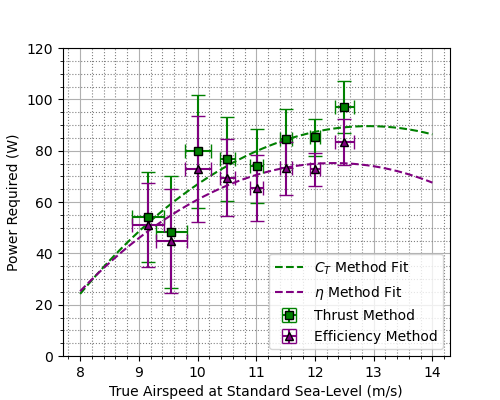

In [13]:
# Plot of Power Required Fits and Data #

plt.figure(figsize=(5,4))
plt.plot(EAS, Peq_ct, label="$C_T$ Method Fit", color='green', linestyle='--')
plt.plot(EAS, Peq_eta, label="$\eta$ Method Fit", color='purple', linestyle='--')
#plt.plot(EAS, Peq_desc, label="Gliding Method Fit", color='orange', linestyle='--')

plt.errorbar(EAS_ave, CDct_ave * 0.5 * 1.225 * EAS_ave**3 * createv.area, xerr=EAS_std, yerr=CDct_std* 0.5 * 1.225 * EAS_ave**3 * createv.area, capsize=5, fmt='sg', label="Thrust Method", markeredgecolor=[0,0,0])
plt.errorbar(EAS_ave, CDeta_ave * 0.5 * 1.225 * EAS_ave**3 * createv.area, xerr=EAS_std, yerr=CDeta_std* 0.5 * 1.225 * EAS_ave**3 * createv.area, capsize=5, fmt='^', color='purple', label="Efficiency Method", markeredgecolor=[0,0,0])
#plt.errorbar(EASdesc_ave, CDdesc_ave* 0.5 * 1.225 * EASdesc_ave**3 * createv.area, xerr=EASdesc_std, yerr=CDdesc_std* 0.5 * 1.225 * EASdesc_ave**3 * createv.area, capsize=5, fmt='o', color='orange', label = "Gliding Method", markeredgecolor=[0,0,0])

plt.xlabel("True Airspeed at Standard Sea-Level (m/s)")
plt.ylabel("Power Required (W)")
plt.ylim([0, 120])
plt.legend()
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':', color='grey')
plt.minorticks_on()
plt.show()

#plt.savefig("Figures/power_req_pres.pdf", bbox_inches='tight')

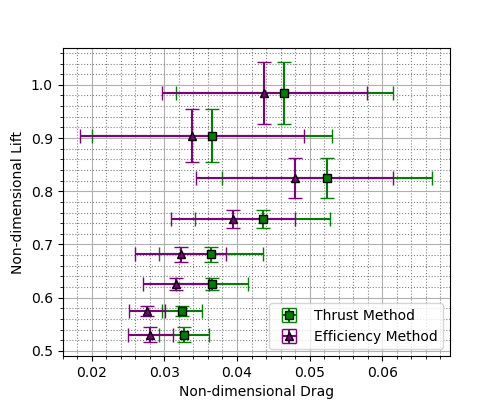

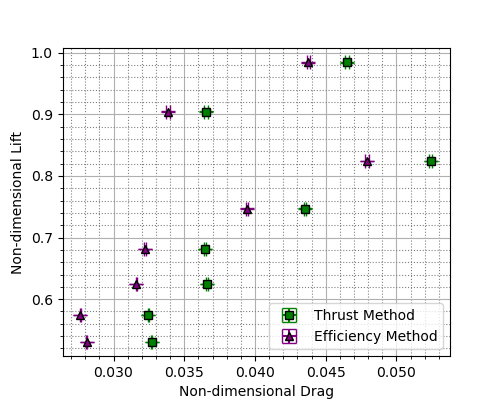

In [14]:
# Drag Polar plots #
plt.figure(figsize=(5,4))
plt.errorbar(CDct_ave, CL_ave, xerr=CDct_std, yerr=CL_std, capsize=5, fmt='sg', label="Thrust Method", markeredgecolor=[0,0,0])
plt.errorbar(CDeta_ave, CL_ave, xerr=CDeta_std, yerr=CL_std, capsize=5, fmt='^', color='purple', label="Efficiency Method", markeredgecolor=[0,0,0])
#plt.errorbar(CDdesc_ave, CLdesc_ave, xerr=CDdesc_std, yerr=CLdesc_std, capsize=5, fmt='o', color='orange', label = "Gliding Method", markeredgecolor=[0,0,0])
plt.xlabel("Non-dimensional Drag")
plt.ylabel("Non-dimensional Lift")
plt.legend()
plt.grid(True)
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':', color='grey')
plt.minorticks_on()
plt.tight_layout
plt.show()
#plt.savefig("Figures/polar_scatter_pres.pdf", bbox_inches='tight')


# 95% Confidence Interval!

plt.figure(figsize=(5,4))
plt.errorbar(CDct_ave, CL_ave, xerr=CDct_95, yerr=CL_95, capsize=5, fmt='sg', label="Thrust Method", markeredgecolor=[0,0,0])
plt.errorbar(CDeta_ave, CL_ave, xerr=CDeta_95, yerr=CL_95, capsize=5, fmt='^', color='purple', label="Efficiency Method", markeredgecolor=[0,0,0])
#plt.errorbar(CDdesc_ave, CLdesc_ave, xerr=CDdesc_std, yerr=CLdesc_std, capsize=5, fmt='o', color='orange', label = "Gliding Method", markeredgecolor=[0,0,0])
plt.xlabel("Non-dimensional Drag")
plt.ylabel("Non-dimensional Lift")
plt.legend()
plt.grid(True)
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':', color='grey')
plt.minorticks_on()
plt.tight_layout
plt.show()
#plt.savefig("Figures/polar_scatter_pres.pdf", bbox_inches='tight')

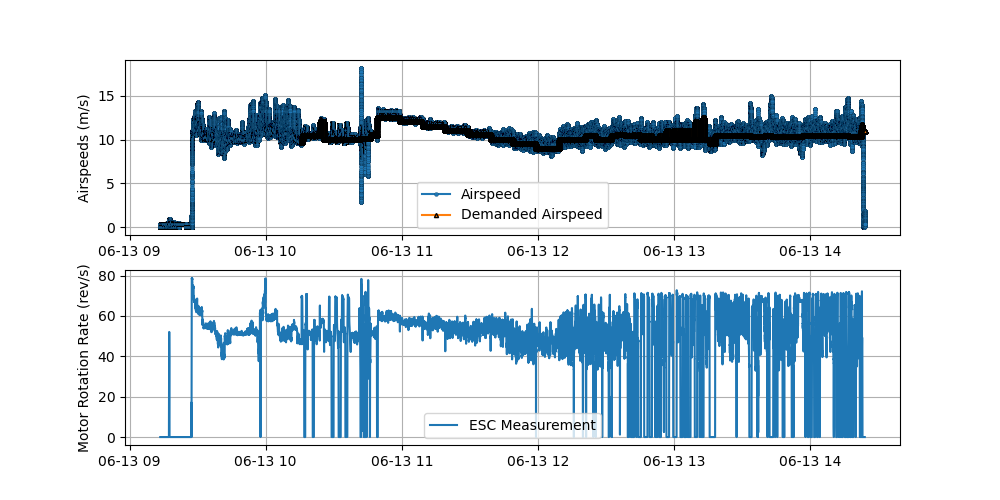

In [15]:
# Plotting true airspeed, with demanded airspeed
plt.figure(figsize=(10,5))
ax1 = plt.subplot(2,1,1)
ax1.plot(df_100Hz.index, v_tas, label="Airspeed", marker='o', markeredgecolor=[0,0,0], markersize=3, markeredgewidth=0.1)
ax1.plot(df_100Hz.index, v_dem, label="Demanded Airspeed", marker='^', markeredgecolor=[0,0,0], markersize=3)
ax1.set_ylabel("Airspeeds (m/s)")
ax1.grid(which='major', linestyle='-')
ax1.grid(which='minor', linestyle=':', color='grey')
plt.legend()

ax2 = plt.subplot(2,1,2, sharex=ax1)
ax2.plot(df.index, n, label='ESC Measurement')
ax2.set_ylabel("Motor Rotation Rate (rev/s)")
ax2.grid(which='major', linestyle='-')
ax2.grid(which='minor', linestyle=':', color='grey')
plt.legend()

plt.show()


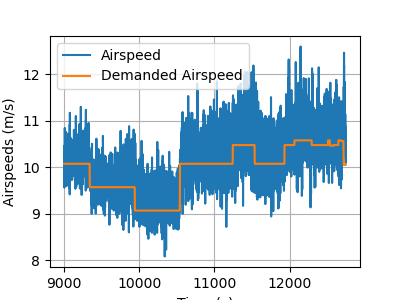

FileNotFoundError: [Errno 2] No such file or directory: 'Figures/demanded_airspeed.pdf'

In [16]:
# Showing bad data #
time = np.linspace(0, (len(v_tas)-1)/100, len(v_tas))
#interval = [9000*100:12750*100]

plt.figure(figsize=(4,3))
plt.plot(time[9000*100:12750*100], v_tas[9000*100:12750*100], label="Airspeed", marker='None', markeredgecolor=[0,0,0], markersize=3, markeredgewidth=0.05)
plt.plot(time[9000*100:12750*100], v_dem[9000*100:12750*100], label="Demanded Airspeed", marker='None', markeredgecolor=[0,0,0], markersize=3, markeredgewidth=0.05)
plt.ylabel("Airspeeds (m/s)")
plt.xlabel("Time (s)")
plt.grid(which='major', linestyle='-')
plt.legend()
plt.tight_layout
plt.grid(True)
plt.show()
plt.savefig("Figures/demanded_airspeed.pdf", bbox_inches='tight')

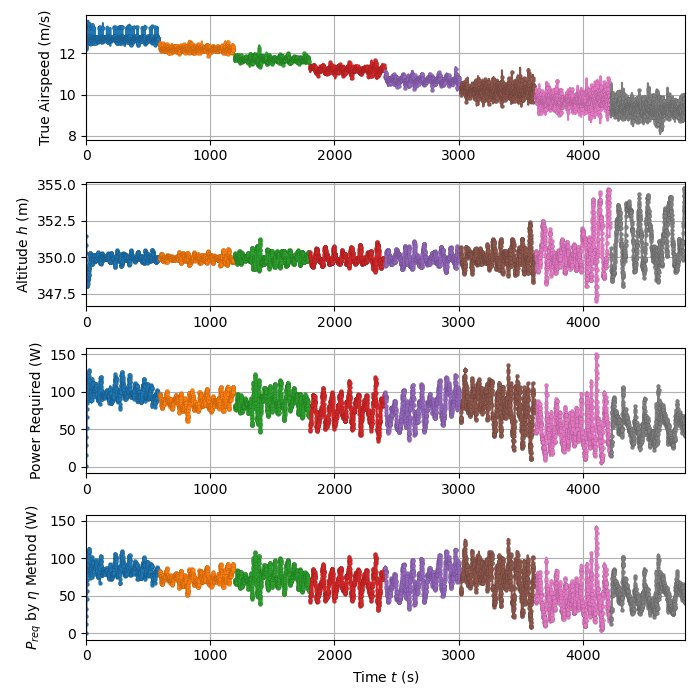

FileNotFoundError: [Errno 2] No such file or directory: 'Figures/cruise_overview_pres.pdf'

In [ ]:
# Plotting Steady-level Data Runs #
markerstyle = 'o'
markerevery = 80
markedgew = 0.05
plt.figure(figsize=(7,7))
ax1 = plt.subplot(4,1,1)
t_init = 0
for i in range(len(masks)):
    time_s = np.linspace(t_init, (len(v_tas[masks[i]])-1)/100 + t_init, len(v_tas[masks[i]]))
    ax1.plot(time_s, v_tas[masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax1.set_ylabel("True Airspeed (m/s)")
ax1.grid(which='major', linestyle='-')
ax1.grid(which='minor', linestyle=':', color='grey')
ax1.autoscale(enable=True, axis='x', tight=True)

ax0 = plt.subplot(4,1,2, sharex=ax1)
t_init = 0
for i in range(len(masks)):
    time_s = np.linspace(t_init, (len(v_tas[masks[i]])-1)/100 + t_init, len(v_tas[masks[i]]))
    ax0.plot(time_s, h[masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax0.set_ylabel("Altitude $h$ (m)")
ax0.grid(which='major', linestyle='-')
ax0.grid(which='minor', linestyle=':', color='grey')
ax0.autoscale(enable=True, axis='x', tight=True)

ax2 = plt.subplot(4,1,3, sharex=ax1)
t_init = 0
for i in range(len(masks)):
    time_s = np.linspace(t_init, (len(v_tas[masks[i]])-1)/100 + t_init, len(v_tas[masks[i]]))
    ax2.plot(time_s, P_ct[masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax2.set_ylabel("Power Required (W)")
ax2.grid(which='major', linestyle='-')
ax2.grid(which='minor', linestyle=':', color='grey')
ax2.autoscale(enable=True, axis='x', tight=True)

ax3 = plt.subplot(4,1,4, sharex=ax1, sharey=ax2)
t_init = 0
for i in range(len(masks)):
    time_s = np.linspace(t_init, (len(v_tas[masks[i]])-1)/100 + t_init, len(v_tas[masks[i]]))
    ax3.plot(time_s, P_eta[masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax3.set_ylabel("$P_{req}$ by $\eta$ Method (W)")
ax3.set_xlabel("Time $t$ (s)")
ax3.grid(which='major', linestyle='-')
ax3.grid(which='minor', linestyle=':', color='grey')
ax3.autoscale(enable=True, axis='x', tight=True)

plt.tight_layout()
plt.show()
# plt.savefig("Figures/cruise_overview_pres.pdf", bbox_inches='tight')

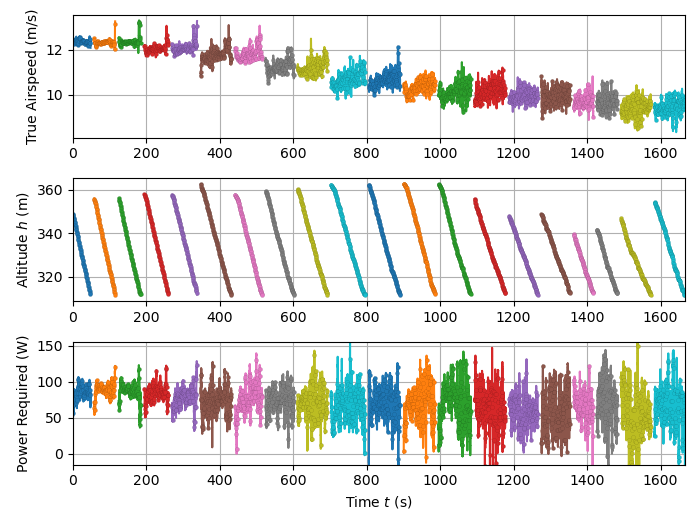

In [ ]:
# Plotting Descending Data Runs #
markerstyle = 'o'
markerevery = 80
markedgew = 0.05


plt.figure(figsize=(7,5.25))
ax1 = plt.subplot(3,1,1)
t_init = 0
for i in range(len(desc_masks)):
    time_s = np.linspace(t_init, (len(v_tas[desc_masks[i]])-1)/100 + t_init, len(v_tas[desc_masks[i]]))
    ax1.plot(time_s, v_tas[desc_masks[i]], marker=markerstyle, markevery=markerevery, markeredgecolor=[0,0,0], markersize=3, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax1.set_ylabel("True Airspeed (m/s)")
ax1.grid(which='major', linestyle='-')
ax1.grid(which='minor', linestyle=':', color='grey')
ax1.autoscale(enable=True, axis='x', tight=True)


ax2 = plt.subplot(3,1,2, sharex=ax1)
t_init = 0
for i in range(len(desc_masks)):
    time_s = np.linspace(t_init, (len(v_tas[desc_masks[i]])-1)/100 + t_init, len(v_tas[desc_masks[i]]))
    ax2.plot(time_s, h[desc_masks[i]], marker=markerstyle, markevery=markerevery, markeredgecolor=[0,0,0], markersize=3, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax2.set_ylabel("Altitude $h$ (m)")
ax2.grid(which='major', linestyle='-')
ax2.grid(which='minor', linestyle=':', color='grey')
ax2.autoscale(enable=True, axis='x', tight=True)


ax3 = plt.subplot(3,1,3, sharex=ax2)
t_init = 0
for i in range(len(desc_masks)):
    time_s = np.linspace(t_init, (len(v_tas[desc_masks[i]])-1)/100 + t_init, len(v_tas[desc_masks[i]]))
    ax3.plot(time_s, P_desc[desc_masks[i]], marker=markerstyle, markevery=markerevery, markeredgecolor=[0,0,0], markersize=3, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax3.set_ylabel("Power Required (W)")
ax3.set_xlabel("Time $t$ (s)")
ax3.set_ylim([-15, 155])
ax3.grid(which='major', linestyle='-')
ax3.grid(which='minor', linestyle=':', color='grey')
ax3.autoscale(enable=True, axis='x', tight=True)


plt.tight_layout()
plt.show()
plt.savefig("Figures/glide_overview_pres.pdf", bbox_inches='tight')

In [ ]:
k_ct = (polar_ct[1]*createv.AR*np.pi)**-1
k_eta = (polar_eta[1]*createv.AR*np.pi)**-1
k_desc = (polar_desc[1]*createv.AR*np.pi)**-1

NameError: name 'polar_desc' is not defined